# Introduction

In this project, I explore a dataset containing a list of daily trending youtube videos in Canada from 2017-2018. I developed a random forest model to predict the number of days a video will remain trending based on number of views, number of days from publication date to trending date, and comment count. 

##  Set up 

First, let's import the required libraries.

In [572]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime as dt
import math

import warnings
warnings.filterwarnings('ignore')


We will be using two datasets. The first contains data about tranding videos on youtube across Canada for the years 2017-2018. The second contains the information about the genre of the trending videos, 

In [573]:
ca_videos = pd.read_csv('/home/carla/PythonProjects/YoutubeAnalysis/Data/youtube-new/CAvideos.csv')
ca_categories = pd.read_json('/home/carla/PythonProjects/YoutubeAnalysis/Data/youtube-new/CA_category_id.json')

# Exploratory Data Analysis & Basic Data Cleanup 

Let's first get a quick preview of what the dataset looks like. 

In [574]:
# quick preview of dataset
ca_videos.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


In [575]:
print('Shape of data: ', ca_videos.shape)

Shape of data:  (40881, 16)


The dataset has 40,881 entries and 16 variables.

## Variables: Overview

In [576]:
ca_videos.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

The variables above show the daily characteristics of trending youtube videos in 2017-2018. 

In [577]:
ca_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40881 entries, 0 to 40880
Data columns (total 16 columns):
video_id                  40881 non-null object
trending_date             40881 non-null object
title                     40881 non-null object
channel_title             40881 non-null object
category_id               40881 non-null int64
publish_time              40881 non-null object
tags                      40881 non-null object
views                     40881 non-null int64
likes                     40881 non-null int64
dislikes                  40881 non-null int64
comment_count             40881 non-null int64
thumbnail_link            40881 non-null object
comments_disabled         40881 non-null bool
ratings_disabled          40881 non-null bool
video_error_or_removed    40881 non-null bool
description               39585 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


15 of the 16 variables are comprehensive and have only non-null values. However, the variable 'description' has 39,585 non-null values and 1296 missing values.

## Categorical Data

In [578]:
##description of categorical data
#ca_videos.category_id = ca_videos.category_id.astype('object')
ca_videos.describe(include = np.object)

,video_id,trending_date,title,channel_title,publish_time,tags,thumbnail_link,description
count,40881,40881,40881,40881,40881,40881,40881,39585
unique,24427,205,24573,5076,23613,20157,24422,22345
top,VYOjWnS4cMY,17.10.12,Drake - God's Plan (Official Audio),SET India,2017-12-20T23:00:00.000Z,[none],https://i.ytimg.com/vi/VYOjWnS4cMY/default.jpg,Subscribers Link: http://bit.ly/2qb69dZ\n\nCon...
freq,8,200,15,192,11,2385,8,130


We can see here that there are 24,427 trending videos in the span of 205 days. Because title has more unique entries (24,573) than video_id (24,427) we can see that some videos had their titles changed. There are also 17 different categories, and 5,076 unique channels.

Let's take a closer look at the trending dates, publish times, and categories.

### Trending Date

In [579]:
ca_videos['trending_date'] = pd.to_datetime(ca_videos['trending_date'], format='%y.%d.%m').dt.date
ca_videos.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,2017-11-14,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


In [580]:
ca_videos['trending_date'].sort_values()
print('Data collection start date: ', ca_videos['trending_date'].min())
print('Date collection end date: ', ca_videos['trending_date'].max())

Data collection start date:  2017-11-14
Date collection end date:  2018-06-14


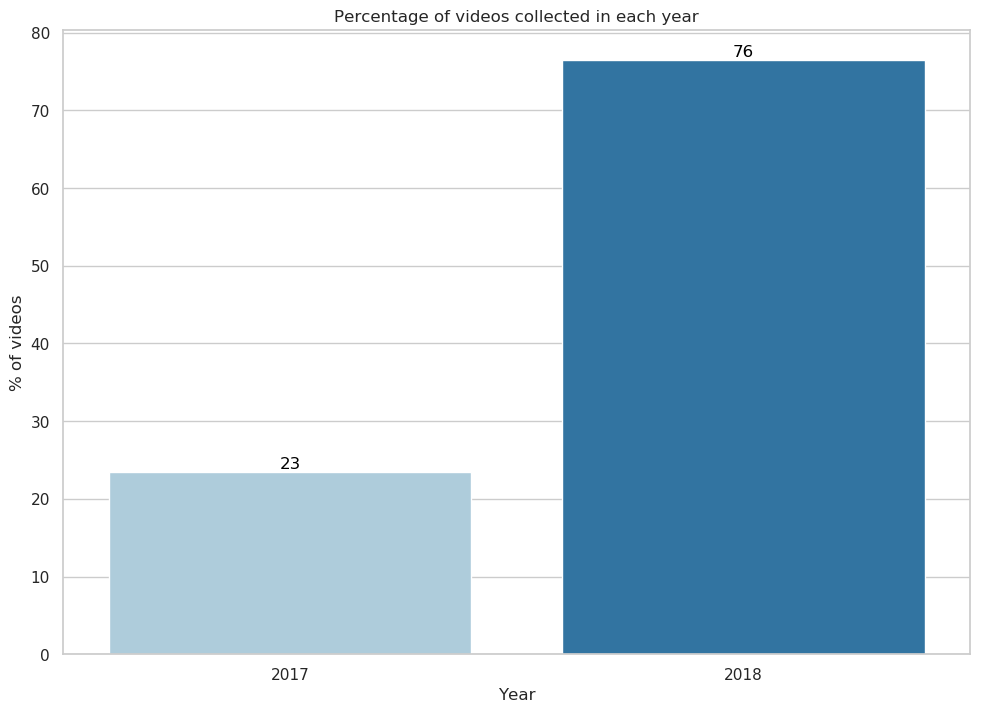

In [581]:
data_collection = pd.value_counts(ca_videos['trending_date'].apply(lambda x: x.year)).to_frame().reset_index()
data_collection = data_collection.rename(columns = {'index' : 'Year', 'trending_date': '% of videos'})
data_collection['% of videos'] = ((data_collection['% of videos']/data_collection['% of videos'].sum())*100).round(2)

sns.set(style = 'whitegrid')

ax = sns.barplot(x = 'Year', y =  '% of videos', data = data_collection, palette = sns.color_palette('Paired'))
ax.set(title = 'Percentage of videos collected in each year')

plt.rc('figure', figsize=(8, 5), dpi=100)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')



As we can see 23% of the data was collected in 2017, while 76% of the data was collected in 2018. So, we only have data from the last few months of 2017.

Let's take a look at when the videos were originally published now.

### Publication Date

In [582]:
ca_videos['publish_time'] = pd.to_datetime(ca_videos['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.date
print('Original publication start date: ', ca_videos['publish_time'].min())
print('Original publication end date: ', ca_videos['trending_date'].max())

Original publication start date:  2008-01-13
Original publication end date:  2018-06-14


Here we can see that some videos that were trending in 2017/2018 could have been published as far back as 2008.

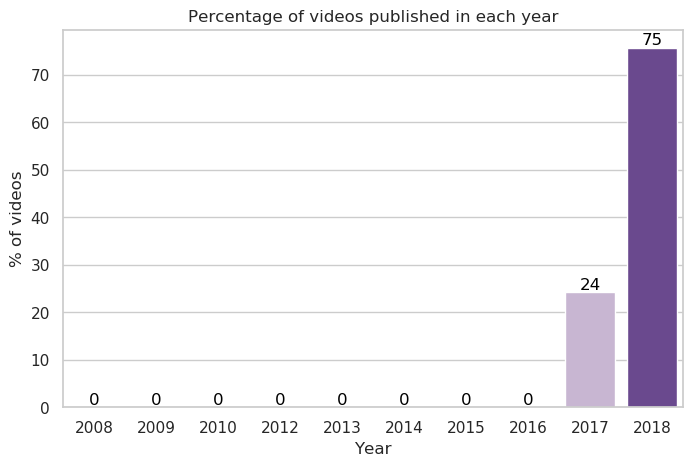

In [583]:
published = pd.value_counts(ca_videos['publish_time'].apply(lambda x: x.year)).to_frame().reset_index()
published = published.rename(columns = {'index' : 'Year', 'publish_time': '% of videos'})

published['% of videos'] = ((published['% of videos']/published['% of videos'].sum())*100).round(2)

sns.set(style = 'whitegrid')

ax = sns.barplot(x = 'Year', y =  '% of videos', data = published, palette = sns.color_palette('Paired'))
ax.set(title = 'Percentage of videos published in each year')

plt.rc('figure', figsize=(8, 5), dpi=100)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')


Most of the videos were published in 2017 and 2018. About 1% were published in previous years (2008-2016). This is interesting to explore to determine what types of videos are likely to resurface and become trending years after the original oublication date.

## Categories

In [584]:
categories = {int(category['id']): category['snippet']['title'] for category in ca_categories['items']}
ca_videos["category_name"] = ca_videos["category_id"].map(categories)
categories

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In the description above, we determined that #24 is the category with the most trending videos. Here we can see that it's entertainment.

## Boolean Data

Now we evaluate the boolean data, before moving on to the numerical data. 
There are three boolean variables: comment_disabled, ratings_disabled, and video_error_or_removed.

In [585]:
bool_data = ca_videos.select_dtypes(include = 'bool').apply(pd.Series.value_counts)
print(bool_data)
print()
print('Number of videos with comments and ratings disabled that have been removed: ', 
      len(ca_videos[(ca_videos["comments_disabled"] == True) & (ca_videos["ratings_disabled"] == True) & (ca_videos['video_error_or_removed'] == True)]))
print('Number of videos with both comments and ratings disabled: ',  
      len(ca_videos[(ca_videos["comments_disabled"] == True) & (ca_videos["ratings_disabled"] == True)]))

       comments_disabled  ratings_disabled  video_error_or_removed
False              40298             40602                   40854
True                 583               279                      27

Number of videos with comments and ratings disabled that have been removed:  0
Number of videos with both comments and ratings disabled:  63


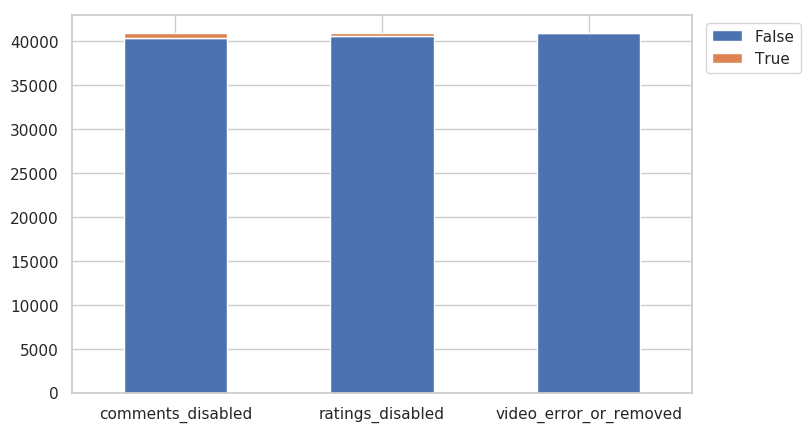

In [586]:
bool_data = bool_data.transpose()
bool_data.plot.bar(stacked = True)
plt.xticks(rotation = 'horizontal')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

Clearly a very low percentage of videos have disabled comments, ratings, or have been removed due to error. 

In [587]:
ca_videos.loc[ca_videos['video_error_or_removed'] == True].head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
4373,bUjlYfYDoeA,2017-12-05,Deleted video,CBCDrama,24,2017-12-04,"سابع جار|""مسلسل سابع جار""|""sab3 gar""|""سابع جار...",431929,2545,264,1016,https://i.ytimg.com/vi/wpAmlGiQbiE/default.jpg,False,False,True,مسلسل سابع جار | الحلقة الرابعة والثلاثون | 34...,Entertainment
10257,4PD8dRaM8Uc,2018-01-04,Deleted video,SET India,24,2018-01-02,"true events|""extramarital affair""|""fight""|""set...",208914,1026,132,114,https://i.ytimg.com/vi/hbw2IQCRlDk/default.jpg,False,False,True,Click here to subscribe to SonyLIV: http://www...,Entertainment
10547,LJsbf7KNVCA,2018-01-05,Deleted video,Torontomapleleafs951,17,2018-01-05,"Joe Thornton|""fights""|""Nazem Kadri""|""Toronto M...",17584,50,7,45,https://i.ytimg.com/vi/n4YzfOI_LEI/default.jpg,False,False,True,Joe Thornton fights Nazem Kadri - Sharks vs Le...,Sports
12011,7qmSwj8Pwys,2018-01-15,Deleted video,PewDiePie,23,2018-01-13,"pewdiepie|""mad lad""",3954942,344105,7173,31539,https://i.ytimg.com/vi/RkvczNWh9ZM/default.jpg,False,False,True,|AD| Shop and save on the HONOR 7X Lucky Bag p...,Comedy
15318,SOeGkrOx0iA,2018-01-31,Deleted video,Comedy Central UK,23,2018-01-30,"comedy central|""comedy central uk""|""the daily ...",426346,5458,332,670,https://i.ytimg.com/vi/ofRoCRKVMrw/default.jpg,False,False,True,President Trump chats with his old pal and Cel...,Comedy


While, videos with comments_disabled and ratings_disabled might give us some insight, videos that were removed and/or had an error can be dropped. We can see that some of them have titles such as 'deleted videos' and or other missing values. Given the small number of deleted videos, the dataset will not be majorily influenced by removing the entries with deleted videos and the variables video_error_or_removed.

In [588]:
#delete rows and columns
ca_videos = ca_videos[~ca_videos.video_error_or_removed]
del ca_videos['video_error_or_removed']

## Numerical Data Exploration

In [589]:
ca_videos.describe(include = [np.number])

,category_id,views,likes,dislikes,comment_count
count,40854.000000,4.085400e+04,4.085400e+04,4.085400e+04,4.085400e+04
mean,20.800778,1.146868e+06,3.957603e+04,2.008885e+03,5.041246e+03
std,6.768405,3.391576e+06,1.327149e+05,1.901425e+04,2.158361e+04
min,1.000000,7.330000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,20.000000,1.438938e+05,2.192000e+03,9.900000e+01,4.170000e+02
50%,24.000000,3.711760e+05,8.780500e+03,3.030000e+02,1.301000e+03
75%,24.000000,9.631840e+05,2.870450e+04,9.500000e+02,3.711000e+03
max,43.000000,1.378431e+08,5.053338e+06,1.602383e+06,1.114800e+06


We can see that most data points in likes, dislikes, and comment_count are fairly close to the mean. However, the views data points seem to be more spread out. It's possible that there are outliers where videos become trending with fewer/more views, likes, or comment counts. It's also possible for videos with disabled comments and/or ratings to make it to the trending list. 

We can also see that the number of views can be as low as 733 and as high as 137, 843, 100. 

Let's visualize their distribution to get a better idea.

### Views Distribution

In [590]:
print('Skewness: ', ca_videos['views'].skew())
print('Kurtosis: ', ca_videos['views'].kurtosis())
ca_videos['views'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

Skewness:  13.487878353343497
Kurtosis:  306.4337888945975


count    4.085400e+04
mean     1.146868e+06
std      3.391576e+06
min      7.330000e+02
15%      8.580660e+04
30%      1.767076e+05
50%      3.711760e+05
65%      6.380289e+05
80%      1.234219e+06
95%      4.090188e+06
max      1.378431e+08
Name: views, dtype: float64

We can also see that the number of views can be as low as 733 and as high as 137, 843, 100. 

50% of videos have 176,707 views or less and the majority of videos (95%) have 4,090,188. However, we can see that 80% of videos have around 1 million views or less, which means that only 15% of the 95% have views between 2 and 4 million.

We can clearly see that the data are fairly spread out, especially as the skewness and kurtosis are very high,

To put these numbers in perspective and to minimize the visibility of outliers, let's visualize the distribution of videos with less than 4,500,000 views.

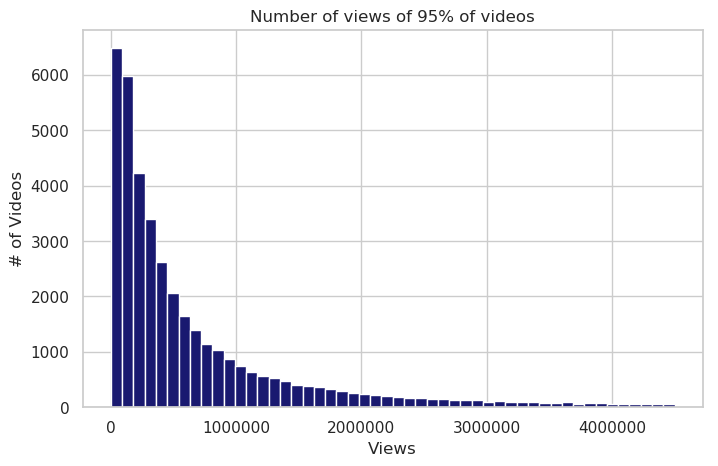

In [591]:
ax = sns.distplot(ca_videos[ca_videos["views"] < 4.5e6]["views"], kde = False, color = 'midnightblue', 
                  hist_kws = {'alpha': 1})
ax.set(xlabel = 'Views', ylabel = '# of Videos')
ax.set(title = "Number of views of 95% of videos")
plt.show()

### Likes Distribution

In [592]:
print('Skewness: ', ca_videos['likes'].skew())
print('Kurtosis: ', ca_videos['likes'].kurtosis())
ca_videos['likes'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

Skewness:  13.658186679755474
Kurtosis:  302.6995863297036


count    4.085400e+04
mean     3.957603e+04
std      1.327149e+05
min      0.000000e+00
15%      9.790000e+02
30%      2.996900e+03
50%      8.780500e+03
65%      1.747335e+04
80%      3.855780e+04
95%      1.652366e+05
max      5.053338e+06
Name: likes, dtype: float64

Here we can see that the minimum number of likes is 0 but that is likely because some videos have that feature disables. The max can reach as high as 5,053,338. 

95% of videos 165,236 likes or less, while 80% have 38,557 likes. This shows us that the majority of videos do not require a huge amount of likes to become trending. 

We will visualize the spread of videos with 200,000 likes or less. 

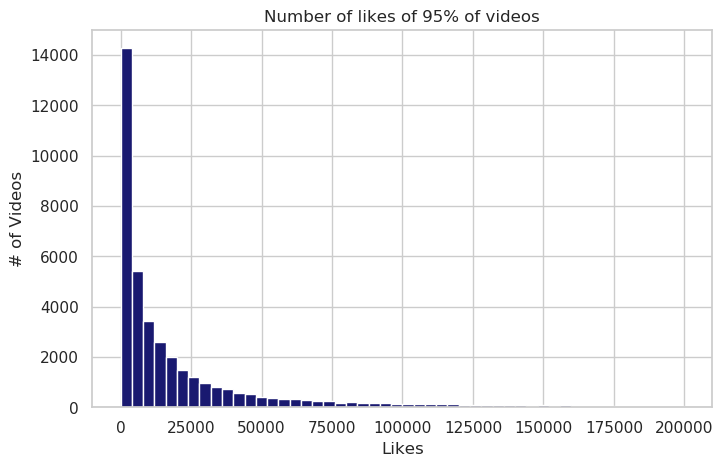

In [593]:
ax = sns.distplot(ca_videos[ca_videos["likes"] < 2e5]["likes"], kde = False, color = 'midnightblue', 
                  hist_kws = {'alpha': 1})
ax.set(xlabel = 'Likes', ylabel = '# of Videos')
ax.set(title = "Number of likes of 95% of videos")
plt.show()

### Dislikes Distribution

In [594]:
print('Skewness: ', ca_videos['dislikes'].skew())
print('Kurtosis: ', ca_videos['dislikes'].kurtosis())
ca_videos['dislikes'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

Skewness:  58.65301337761388
Kurtosis:  4266.013779917809


count    4.085400e+04
mean     2.008885e+03
std      1.901425e+04
min      0.000000e+00
15%      5.200000e+01
30%      1.270000e+02
50%      3.030000e+02
65%      5.800000e+02
80%      1.288000e+03
95%      6.468250e+03
max      1.602383e+06
Name: dislikes, dtype: float64

The minimum number of dislikes can be as low as 0 and as high as 1,602,383. The majority, however, have fewer than 6,468 dislikes. So only 5% if videos are between 6,000-1,000,000. Again 80% of videos have 1,288 ldislikes or less. So, it's less common to have dislikes on trending videos. 

Now we will visualize the distribution of videos with less than 6000 dislikes

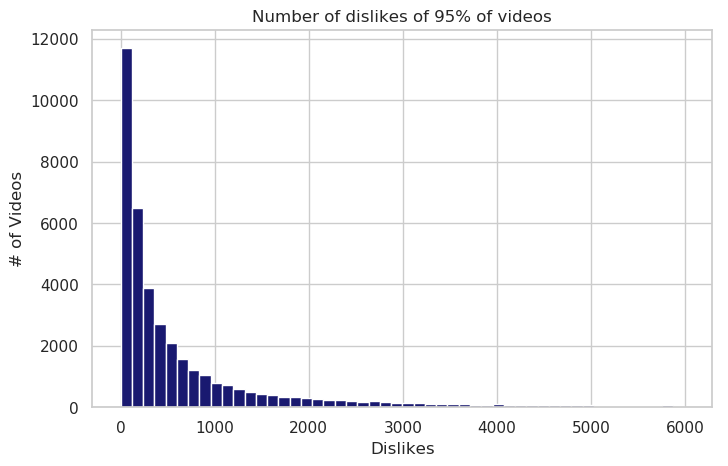

In [595]:
ax = sns.distplot(ca_videos[ca_videos["dislikes"] < 6e3]["dislikes"], kde = False, color = 'midnightblue', 
                  hist_kws = {'alpha': 1})
ax.set(xlabel = 'Dislikes', ylabel = '# of Videos')
ax.set(title = "Number of dislikes of 95% of videos")
plt.show()

### Comment Count Distribution

In [596]:
print('Skewness: ', ca_videos['comment_count'].skew())
print('Kurtosis: ', ca_videos['comment_count'].kurtosis())
ca_videos['comment_count'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

Skewness:  25.15719685088338
Kurtosis:  921.0300177679655


count    4.085400e+04
mean     5.041246e+03
std      2.158361e+04
min      0.000000e+00
15%      1.980000e+02
30%      5.510000e+02
50%      1.301000e+03
65%      2.364000e+03
80%      4.823000e+03
95%      1.918965e+04
max      1.114800e+06
Name: comment_count, dtype: float64

Comment count can go from as low as 0 to as high as 1,114,800. The majority have a count of 19,189 comments or less, while 80% have a comment count of 4,823 or less. 

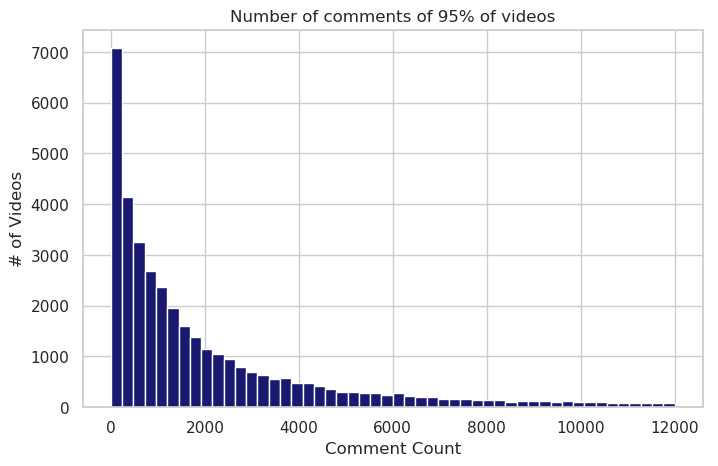

In [597]:
ax = sns.distplot(ca_videos[ca_videos["comment_count"] < 1.2e4]["comment_count"], kde = False, color = 'midnightblue',
                  hist_kws = {'alpha': 1})
         
ax.set(xlabel = 'Comment Count', ylabel = '# of Videos')
ax.set(title = "Number of comments of 95% of videos")
plt.show()

## Recap 

We have so far completed four important data exploration and preprocessing tasks:

1. We looked at the distribution of numerical, categorical, and boolean data. We have seen that videos can be on the trending list for several days and can have a wide range of views, likes, dislikes, and comment count.
2. We dropped any videos that have been removed due to error or otherwise. This made the data more unfirom. 
3. We transformed the trending and publication dates to formats that are more manageable. 
4. We have visualized the distribution of the dataset and now have better idea of what it is made up of. 

Now we will move on to the descriptive statistics before we can perform some analysis. 

# Descriptive Statistics and Data Preprocessing

## Correlation Matrix

Let's start by taking a look at the association between the numerical values.

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text xticklabel objects>)

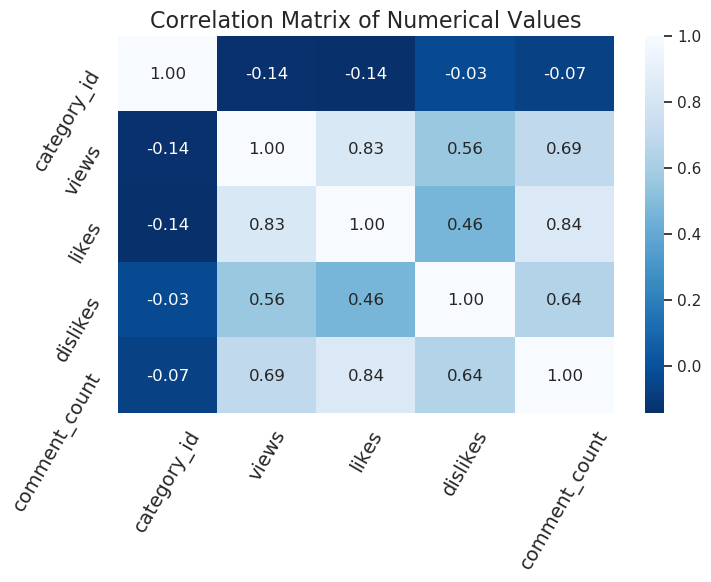

In [598]:
sns.heatmap(ca_videos.select_dtypes(include = ['number']).corr(method = 'pearson'), fmt='0.2f', cmap = 'Blues_r', annot=True)
plt.title('Correlation Matrix of Numerical Values', fontsize=16)

plt.yticks(fontsize=14, rotation=60)
plt.xticks(fontsize=14, rotation = 60)


We can see here that views, likes, dislikes, and comment count are highly correlated. All of them are positively correlated, so as one increases the other also increases.

The number of dislikes seems to correlate the least with the other variables, but it is still interesting to note that the number of views, likes, and comment count do not decrease due to a higher amount of dislikes.

Let's take a look at the variance inflation factors to determine the extent of this multicollinearity. 


In [599]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(ca_videos.select_dtypes(include = ['number']))
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const            11.209791
category_id       1.032226
views             3.883361
likes             6.726006
dislikes          2.144711
comment_count     4.952379
dtype: float64

Clearly, there is multicollinearity. To keep the insight from all variables, we will use a non-parametric model, a random forest analysis and we will perform some feature engeneering to reduce the multicollinearity. This will avoid dropping variables and/or running a principal component analysis. 

## Dislikes Ratio

In [600]:
ca_videos['dislikes_ratio'] = ca_videos['dislikes']/(ca_videos['likes']+ ca_videos['dislikes'])
ca_videos[ca_videos['dislikes_ratio'].apply(lambda x: pd.isna(x))]


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,category_name,dislikes_ratio
67,amEZKmJQ4Io,2017-11-14,Drako - Watch Me Do It [Official Video],babygranderecords,10,2017-10-23,"Drako|""Watch Me Do It""|""watch me""|""migos""|""dap...",25887,0,0,6,https://i.ytimg.com/vi/amEZKmJQ4Io/default.jpg,False,True,PURCHASE / STREAM WATCH ME DO IT https://fanli...,Music,NaN
173,H8IWLEtFt9A,2017-11-14,Intégrale - On n'est pas couché 11 novembre 20...,On n'est pas couché,24,2017-11-12,"onpc|""on n'est pas couche""|""laurent ruquier""|""...",122282,0,0,0,https://i.ytimg.com/vi/H8IWLEtFt9A/default.jpg,True,True,Intégrale - On n'est pas couché 11 novembre 20...,Entertainment,NaN
385,ClwBTkLiivk,2017-11-15,Week 4 Challenge: Check out “My Email Leads”,CREA | ACI,29,2017-11-13,CREA,1898,0,0,0,https://i.ytimg.com/vi/ClwBTkLiivk/default.jpg,True,False,www.realtor.ca/2mins,NaN,NaN
489,HnCU20Cu0fs,2017-11-16,ORIGINAL: Dashcam Norway - Semi truck narrowly...,Transferd AS,29,2017-11-15,"dashcam|""accident""|""traffic""|""safety""|""volvo""|...",2510664,0,0,1641,https://i.ytimg.com/vi/HnCU20Cu0fs/default.jpg,False,True,Copyright Transferd AS - a part of the Firda B...,NaN,NaN
558,5khTN_EnAlY,2017-11-16,（画在脸上的SEPHORA HAUL！) 红色秋冬新品妆容 | 小眼睛怎么hold住大热的...,Rainie Tian,26,2017-11-15,"sephora新品妆容|""2017化妆品新品""|""sephorahaul""|""跟我边聊边画""...",40407,0,0,319,https://i.ytimg.com/vi/5khTN_EnAlY/default.jpg,False,True,ALOHA 小伙伴们! 这次是一个不一样的sephora haul 哈哈 \n今天画了一个妖...,Howto & Style,NaN
579,0ayARJdf7I4,2017-11-16,018 Algebra Lineal 18-10-2011,udearroba,27,2017-11-15,[none],1141,0,0,0,https://i.ytimg.com/vi/0ayARJdf7I4/default.jpg,False,False,Base ortogonal,Education,NaN
584,nqR7jkb3ehM,2017-11-16,Good vybz only,Georgia Webster,22,2017-10-23,[none],1187,0,0,0,https://i.ytimg.com/vi/nqR7jkb3ehM/default.jpg,False,False,NaN,People & Blogs,NaN
790,5khTN_EnAlY,2017-11-17,（画在脸上的SEPHORA HAUL！) 红色秋冬新品妆容 | 小眼睛怎么hold住大热的...,Rainie Tian,26,2017-11-15,"sephora新品妆容|""2017化妆品新品""|""sephorahaul""|""跟我边聊边画""...",68193,0,0,428,https://i.ytimg.com/vi/5khTN_EnAlY/default.jpg,False,True,ALOHA 小伙伴们! 这次是一个不一样的sephora haul 哈哈 \n今天画了一个妖...,Howto & Style,NaN
949,AmUjiyzZWJU,2017-11-18,"Eat Bulaga! (November 18, 2017)",Eat Bulaga!,24,2017-11-18,[none],19484,0,0,3,https://i.ytimg.com/vi/AmUjiyzZWJU/default.jpg,False,True,SUBSCRIBE to our channel now to get exclusive ...,Entertainment,NaN
1069,om-_yJaSW_Y,2017-11-19,GET READY WITH US Feat: JACLYN HILL & MANNY MUA,Laura Lee,26,2017-11-18,"Laura88Lee|""grwm""|""chit chat get ready with me...",523258,0,0,0,https://i.ytimg.com/vi/om-_yJaSW_Y/default.jpg,True,True,"Hey Larlees, todays video is a get ready with ...",Howto & Style,NaN


As expected, the dislikes ratio has null values, because some videos have 0 likes and dislikes. To correct this, we will replace all null values with the value zero.

In [601]:
ca_videos['dislikes_ratio'] = ca_videos['dislikes_ratio'].fillna(value = 0)

## Comment Count Ratio

In [602]:
ca_videos['comment_ratio'] = ca_videos['comment_count']/(ca_videos['comment_count']+ ca_videos['views'])


## Most trending categories

[Text(0.5, 1.0, 'Most Trending Categories')]

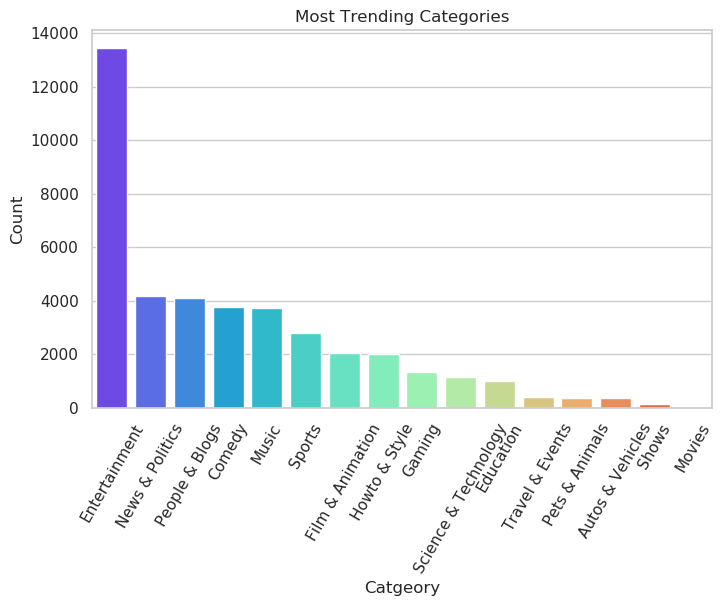

In [603]:
ax = sns.countplot(ca_videos["category_name"], palette = "rainbow",
                   order= ca_videos['category_name'].value_counts().index)
ax.set(xlabel = "Catgeory", ylabel = "Count")
plt.xticks(rotation = 60)
ax.set(title = "Most Trending Categories")


## Top 20 Channels

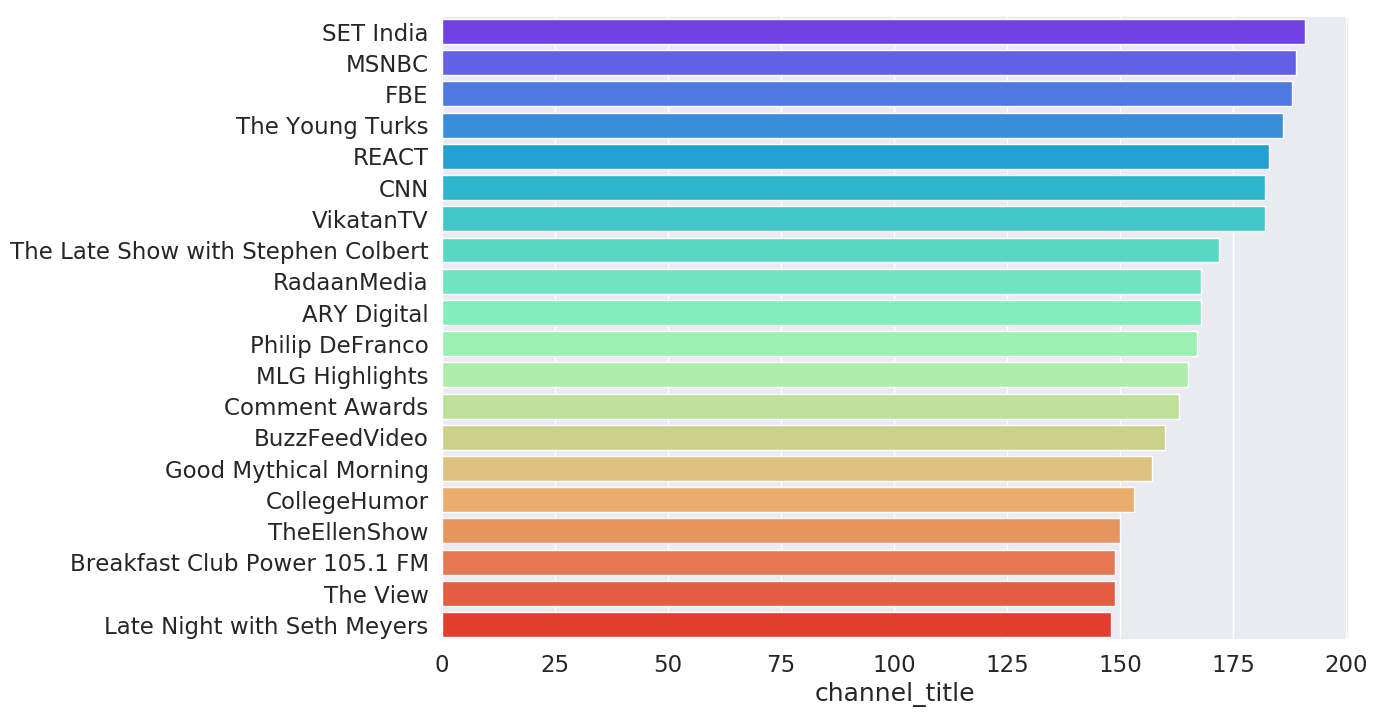

In [604]:
sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
tmp = ca_videos.channel_title.value_counts()[:20]
_ = sns.barplot(y=tmp.index,x=tmp, palette = "rainbow")


## Number of Days Trending

In [605]:
#ca_videos['days_trending'] = ca_videos.groupby('video_id')['video_id'].transform('days_trending')
count = ca_videos['video_id'].value_counts().to_dict()
ca_videos['days_trending'] = ca_videos['video_id'].map(count) 
ca_videos['days_trending'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

count    40854.000000
mean         2.296568
std          1.339718
min          1.000000
15%          1.000000
30%          1.000000
50%          2.000000
65%          3.000000
80%          3.000000
95%          5.000000
max          8.000000
Name: days_trending, dtype: float64

We can see here that the max number of days for a video to remain trending is 8 days, while 95% of them remain trending for 5 days or less.

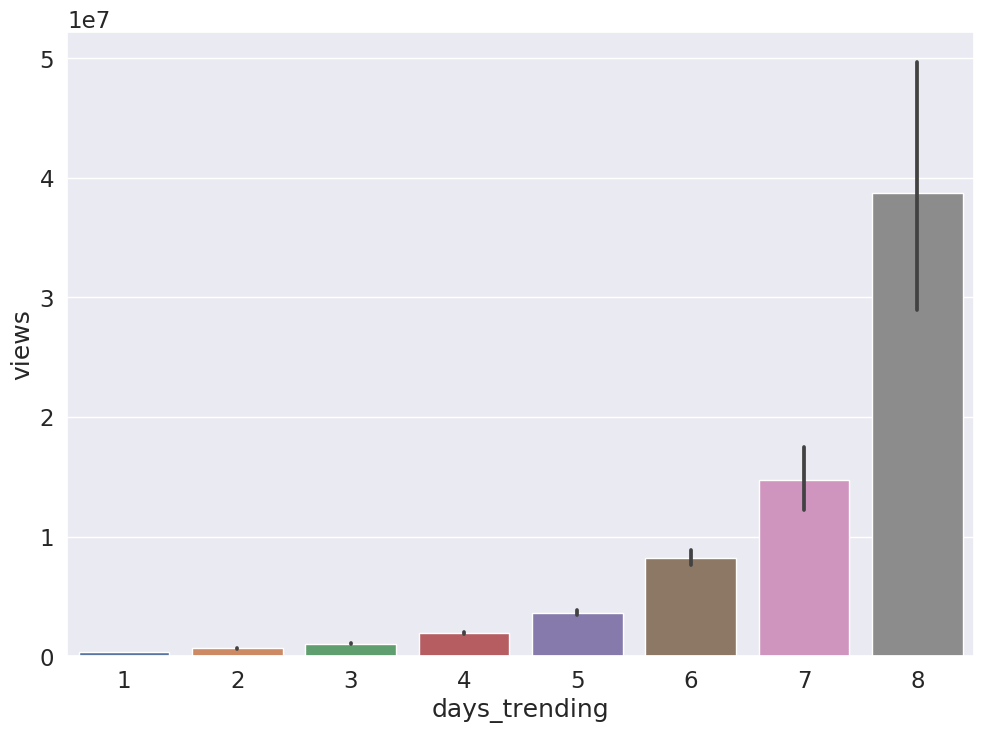

In [606]:
ax = sns.barplot(x = ca_videos.days_trending, y = ca_videos.views, data = ca_videos)

This will serve as our dependent variable.

## Days to Trending

In [607]:
video = ca_videos.set_index(['video_id'])
ca_videos['day_to_trending'] = (ca_videos.trending_date - ca_videos.publish_time).dt.days
ca_videos['day_to_trending'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

count    40854.000000
mean         3.481936
std         59.755681
min          0.000000
15%          1.000000
30%          1.000000
50%          1.000000
65%          2.000000
80%          2.000000
95%          4.000000
max       3658.000000
Name: day_to_trending, dtype: float64

We can see here that most videos take about 4 days or less from publishing date to become trending, while others become trending from the first day. 

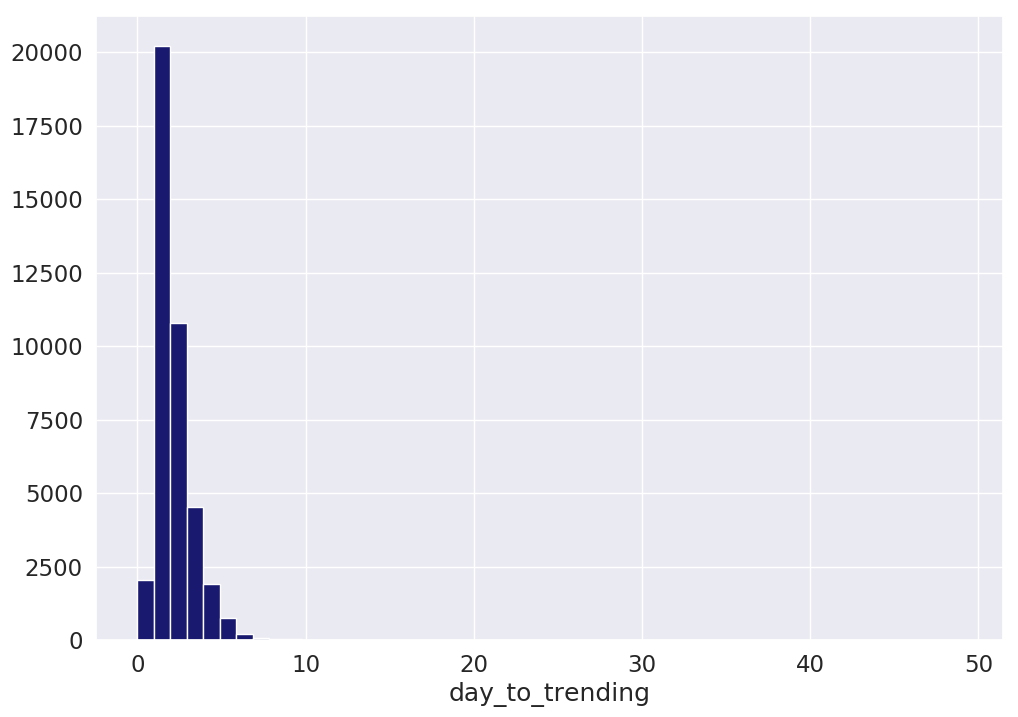

In [608]:
ax = sns.distplot(ca_videos[ca_videos["day_to_trending"] < 50]["day_to_trending"], kde = False, color = 'midnightblue',
                  hist_kws = {'alpha': 1})

## Title Analysis

### Title Length

In [609]:
ca_videos['title_length'] = ca_videos.title.apply(lambda x: len(x))
ca_videos['title_length'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

count    40854.000000
mean        53.723895
std         22.149139
min          1.000000
15%         30.000000
30%         40.000000
50%         51.000000
65%         61.000000
80%         75.000000
95%         95.000000
max        100.000000
Name: title_length, dtype: float64

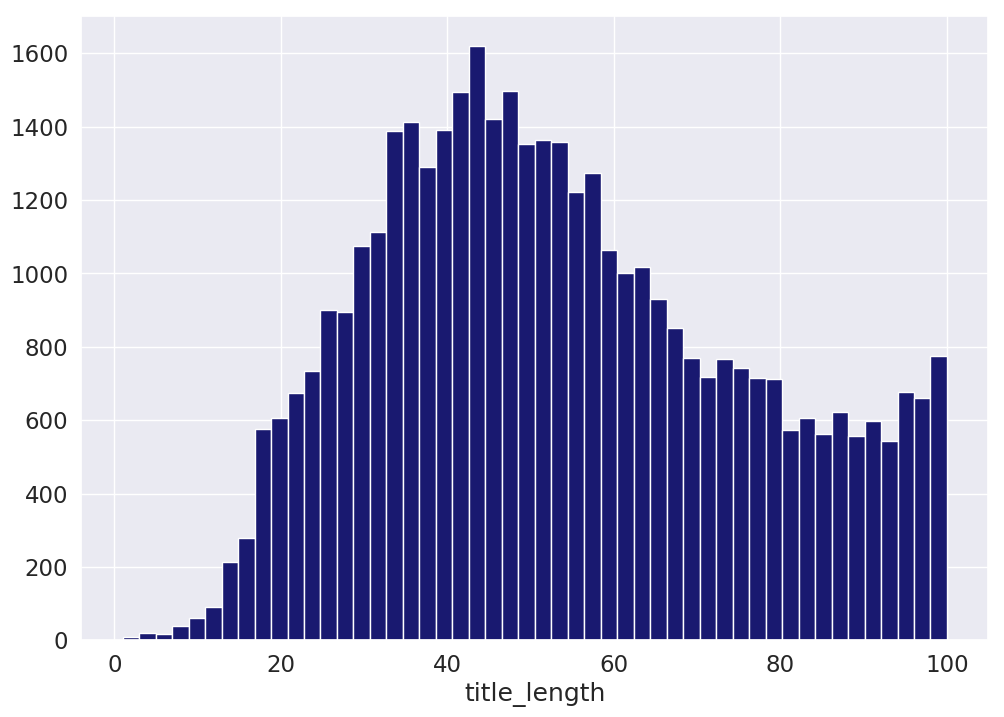

In [610]:
ax = sns.distplot(ca_videos.title_length, kde = False, color = 'midnightblue',
                  hist_kws = {'alpha': 1})

### Contains Capital Titles

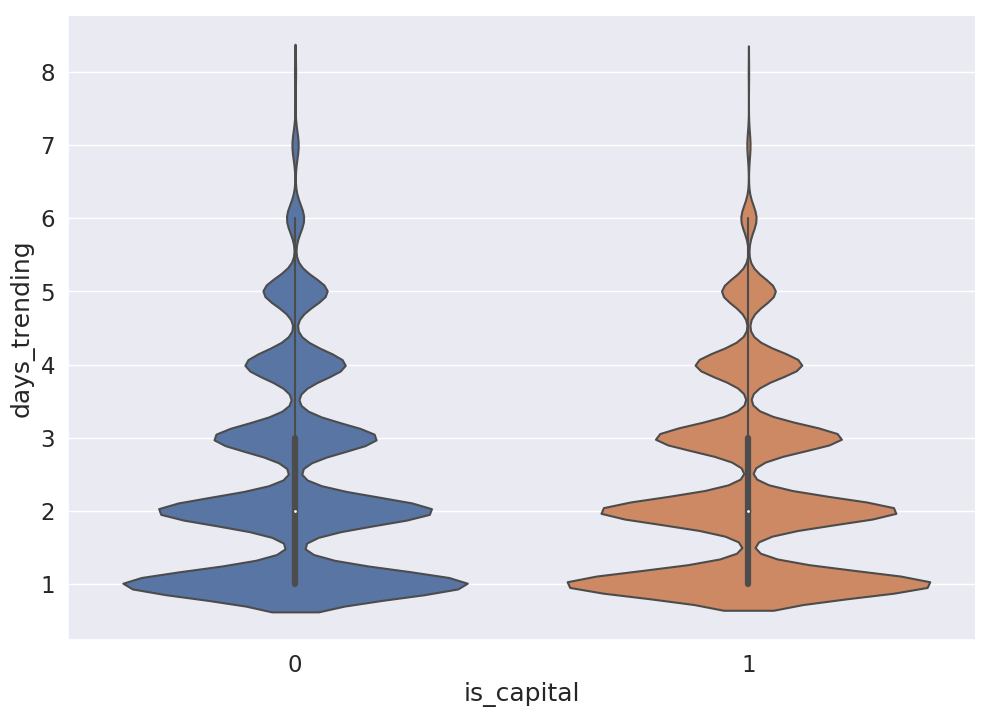

In [611]:
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False

ca_videos["is_capital"] = ca_videos["title"].apply(contains_capitalized_word)
ca_videos["is_capital"] *=1
sns.violinplot(ca_videos['is_capital'], ca_videos['days_trending']) 
sns.despine()

We can see that there's an even distribution of titles that have capital words and titles that don't. We can also see that the more trending a video stays the less likely it has capital words in its title.

# Restructuring the Dataset

In [612]:
data = ca_videos[['category_name','views', 'comment_count', 'dislikes_ratio', 'days_trending', 'day_to_trending', 'title_length', 'is_capital']]

In [613]:
data = pd.get_dummies(data)
data.head()

,views,comment_count,dislikes_ratio,days_trending,day_to_trending,title_length,is_capital,category_name_Autos & Vehicles,category_name_Comedy,category_name_Education,...,category_name_Howto & Style,category_name_Movies,category_name_Music,category_name_News & Politics,category_name_People & Blogs,category_name_Pets & Animals,category_name_Science & Technology,category_name_Shows,category_name_Sports,category_name_Travel & Events
0,17158579,125882,0.052260,4,4,42,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1014651,13030,0.013037,5,1,29,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3191434,8181,0.035270,4,2,53,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2095828,17518,0.014818,4,2,24,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33523622,85067,0.012737,2,5,43,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [614]:
data.corr(method = 'pearson')

,views,comment_count,dislikes_ratio,days_trending,day_to_trending,title_length,is_capital,category_name_Autos & Vehicles,category_name_Comedy,category_name_Education,...,category_name_Howto & Style,category_name_Movies,category_name_Music,category_name_News & Politics,category_name_People & Blogs,category_name_Pets & Animals,category_name_Science & Technology,category_name_Shows,category_name_Sports,category_name_Travel & Events
views,1.000000,0.693079,-0.009343,0.405672,0.000580,-0.013052,-0.022054,-0.015918,-0.015478,-0.028371,...,-0.024490,0.006098,0.222842,-0.075307,-0.035480,-0.014311,0.004374,-0.009271,-0.005656,-0.022642
comment_count,0.693079,1.000000,-0.006536,0.260551,-0.002881,-0.064004,0.011821,-0.009308,0.002335,-0.014946,...,-0.009299,-0.001523,0.132330,-0.043906,-0.014592,-0.000440,0.009487,-0.011295,-0.028720,-0.015894
dislikes_ratio,-0.009343,-0.006536,1.000000,-0.033789,-0.000464,0.126004,-0.050904,-0.015876,-0.109401,-0.031092,...,-0.084723,-0.003529,-0.076803,0.215672,0.069631,-0.041748,-0.030783,0.088026,0.008648,-0.034964
days_trending,0.405672,0.260551,-0.033789,1.000000,0.005332,-0.049190,-0.023880,-0.040801,0.055903,-0.009845,...,-0.041679,0.033503,0.232530,-0.109691,-0.026188,-0.006071,0.013500,-0.040779,-0.077282,-0.002297
day_to_trending,0.000580,-0.002881,-0.000464,0.005332,1.000000,-0.021989,-0.010063,0.000604,0.013745,-0.000476,...,-0.006896,-0.000199,0.008873,-0.008666,0.000934,-0.002428,0.016881,-0.002061,-0.009012,-0.002786
title_length,-0.013052,-0.064004,0.126004,-0.049190,-0.021989,1.000000,0.145196,-0.013952,-0.163118,-0.042780,...,-0.036533,0.023133,0.057578,0.129586,-0.067193,-0.052403,-0.095294,-0.036840,0.170055,0.076003
is_capital,-0.022054,0.011821,-0.050904,-0.023880,-0.010063,0.145196,1.000000,0.022727,-0.052619,-0.036004,...,0.032819,0.012251,-0.047392,-0.032381,-0.056895,0.040620,0.007605,-0.042123,0.073427,0.079410
category_name_Autos & Vehicles,-0.015918,-0.009308,-0.015876,-0.040801,0.000604,-0.013952,0.022727,1.000000,-0.029729,-0.014699,...,-0.021184,-0.001130,-0.029550,-0.031385,-0.031149,-0.008900,-0.015901,-0.005144,-0.025220,-0.009176
category_name_Comedy,-0.015478,0.002335,-0.109401,0.055903,0.013745,-0.163118,-0.052619,-0.029729,1.000000,-0.050280,...,-0.072464,-0.003865,-0.101081,-0.107357,-0.106551,-0.030444,-0.054393,-0.017595,-0.086268,-0.031388
category_name_Education,-0.028371,-0.014946,-0.031092,-0.009845,-0.000476,-0.042780,-0.036004,-0.014699,-0.050280,1.000000,...,-0.035829,-0.001911,-0.049978,-0.053081,-0.052683,-0.015053,-0.026894,-0.008700,-0.042654,-0.015519


## Fitting the Model

In [615]:
from sklearn.model_selection import train_test_split

#convert to numpy
y_label = np.array(data['days_trending'])
x_features = data.drop('days_trending', axis = 1)
features_list = list(x_features.columns)
x_features = np.array(x_features)

x_train, x_test, y_train, y_test = train_test_split(x_features, y_label, test_size = 0.25, random_state = 1)

print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)#data = pd.get_dummies(data)


Training Features Shape: (30640, 22)
Training Labels Shape: (30640,)
Testing Features Shape: (10214, 22)
Testing Labels Shape: (10214,)


In [616]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 1, max_depth = 10, min_samples_split = 2)
rf.fit(x_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

## Prediction

In [617]:
pred = rf.predict(x_test)

### Scores

In [618]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

errors = abs(pred - y_test)
mape = 100*(errors/y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy derived from MAPE score: ', round(accuracy, 2), '%.')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

print('R-sq = {:.2%}'.format(metrics.r2_score(y_test, pred)))

Accuracy derived from MAPE score:  60.47 %.
Mean Absolute Error: 0.7158570691873327
Mean Squared Error: 0.9043096364845011
Root Mean Squared Error: 0.9509519632896822
R-sq = 48.88%


In [619]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: views                Importance: 0.55
Variable: day_to_trending      Importance: 0.23
Variable: comment_count        Importance: 0.09
Variable: dislikes_ratio       Importance: 0.05
Variable: title_length         Importance: 0.04
Variable: category_name_Music  Importance: 0.01
Variable: category_name_Sports Importance: 0.01
Variable: is_capital           Importance: 0.0
Variable: category_name_Autos & Vehicles Importance: 0.0
Variable: category_name_Comedy Importance: 0.0
Variable: category_name_Education Importance: 0.0
Variable: category_name_Entertainment Importance: 0.0
Variable: category_name_Film & Animation Importance: 0.0
Variable: category_name_Gaming Importance: 0.0
Variable: category_name_Howto & Style Importance: 0.0
Variable: category_name_Movies Importance: 0.0
Variable: category_name_News & Politics Importance: 0.0
Variable: category_name_People & Blogs Importance: 0.0
Variable: category_name_Pets & Animals Importance: 0.0
Variable: category_name_Science & Tech

The three most important predictors appear to be views (55%), days_to_trending (23%), and to a lesser extent, comment_count(9%).

The rest do not seem to have an impact on the number of days a video remains trending. 

We can remove the irrelevant variables to create a more robust model.

## Model Improvement

In [620]:
#convert to numpy
y_label = np.array(data['days_trending'])
x_features = data[['views', 'day_to_trending', 'comment_count']]
features_list = list(x_features.columns)
x_features = np.array(x_features)

x_train, x_test, y_train, y_test = train_test_split(x_features, y_label, test_size = 0.25, random_state = 1)

print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)#data = pd.get_dummies(data)


Training Features Shape: (30640, 3)
Training Labels Shape: (30640,)
Testing Features Shape: (10214, 3)
Testing Labels Shape: (10214,)


In [621]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 1, max_depth = 10, min_samples_split = 2)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [622]:
errors = abs(pred - y_test)
mape = 100*(errors/y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy derived from MAPE score: ', round(accuracy, 2), '%.')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

print('R-sq = {:.2%}'.format(metrics.r2_score(y_test, pred)))

Accuracy derived from MAPE score:  59.04 %.
Mean Absolute Error: 0.7414119346393507
Mean Squared Error: 0.955878251870048
Root Mean Squared Error: 0.977690263769691
R-sq = 45.96%


While the MAPE score appears to be average, the R-squared is 45.96% indicating a robust model.

The model retains approximately the same level of accuracy with less variables. 

In [623]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: views                Importance: 0.62
Variable: day_to_trending      Importance: 0.25
Variable: comment_count        Importance: 0.13


Finally, we have extracted three variables that are relevant in predicting the number of days a video will remain trending. 
Next, we will take a look at the decision tree to see how the decision is made.

### Formula

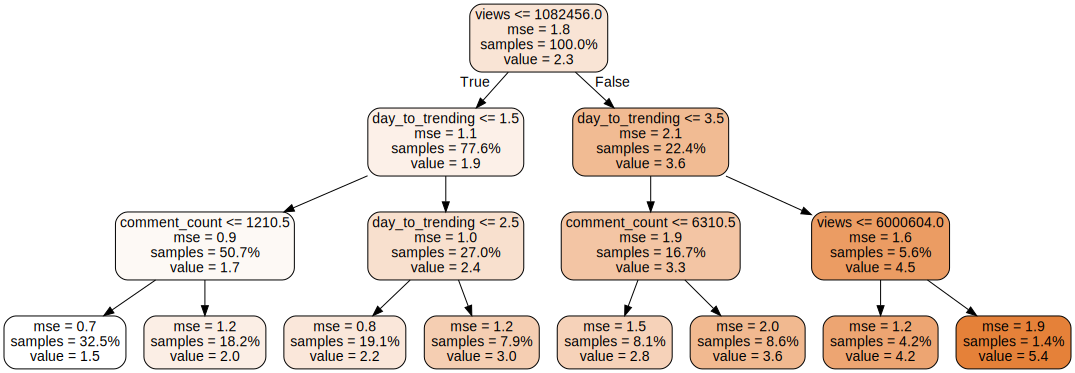

In [624]:
from sklearn.tree import export_graphviz
import pydot


tree = rf.estimators_[5]
graph = export_graphviz(tree1, out_file = None, feature_names = features_list, rounded = True, 
                        precision = 1, max_depth = 5, filled = True, proportion = True)


graphviz.Source(graph)


# Conclusion 

In this project, we explored the characteristics of trending youtube videos in Canada from 14/11/2017 to 14/06/2018 and trained a random forest model to predict the number of days a video will remain trending based on those characteristics.

We found:
- Most videos have less than 1 million views, but can have as high as 140 million views.
- Most videos have less than 40,000 likes, but can have as high as 5 million likes.
- Most videos have less than 1,000 dislikes, but can have as high as 1 million dislikes.
- Most videos have less than 4,000 comments, but can have as high as 1 million comments.
- The most trending videos are in the entertainment section, followed by news & politics, people & blogs, comedy, and music.
- The top 5 channels are: SET India, MSNBC, FBE, The Young Turks, REACT, CNN. 
- The top 20 videos are trending approximately the same amount of time.
- Most videos trend for 3 days, but can remain on the list for 8 days.
- Most days hit the trending list after 4 days of getting published, while 50% are trending after a single day.

Furthermore, we developed a random forest model that can predict the number of days a video will remain trending using three predictors:

- Number of views (62% impact)
- Number of days from publishing date to trending date (23% impact)
- Comment count (13% impact)

The tree above can be used to make these predictions. 